In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve

def cosinus_signal_func(freq = None, T = None, init_phase = 0):
    if freq:
        w = 2 * np.pi * freq
    elif T:
        w = 2 * np.pi / T
    else:
        return None
    cos_func = lambda t: np.cos(t * w + init_phase)

    return cos_func

def rec_imp(t):
    t_r = np.floor(t)
    if t_r % 2 == 0:
        return 2
    else:
        return -2

def calc_signal(s_func, t_start = 0, t_end = None, steps_cnt = None, noised=False):
    if t_end is None:
        t_end = 2
    if steps_cnt is None:
        steps_cnt = 250

    time_series = np.linspace(t_start, t_end, steps_cnt)
    signal_vals = np.array([s_func(t) for t in time_series])
    if noised: signal_vals += np.random.normal(0, 1, signal_vals.shape)

    return signal_vals, time_series

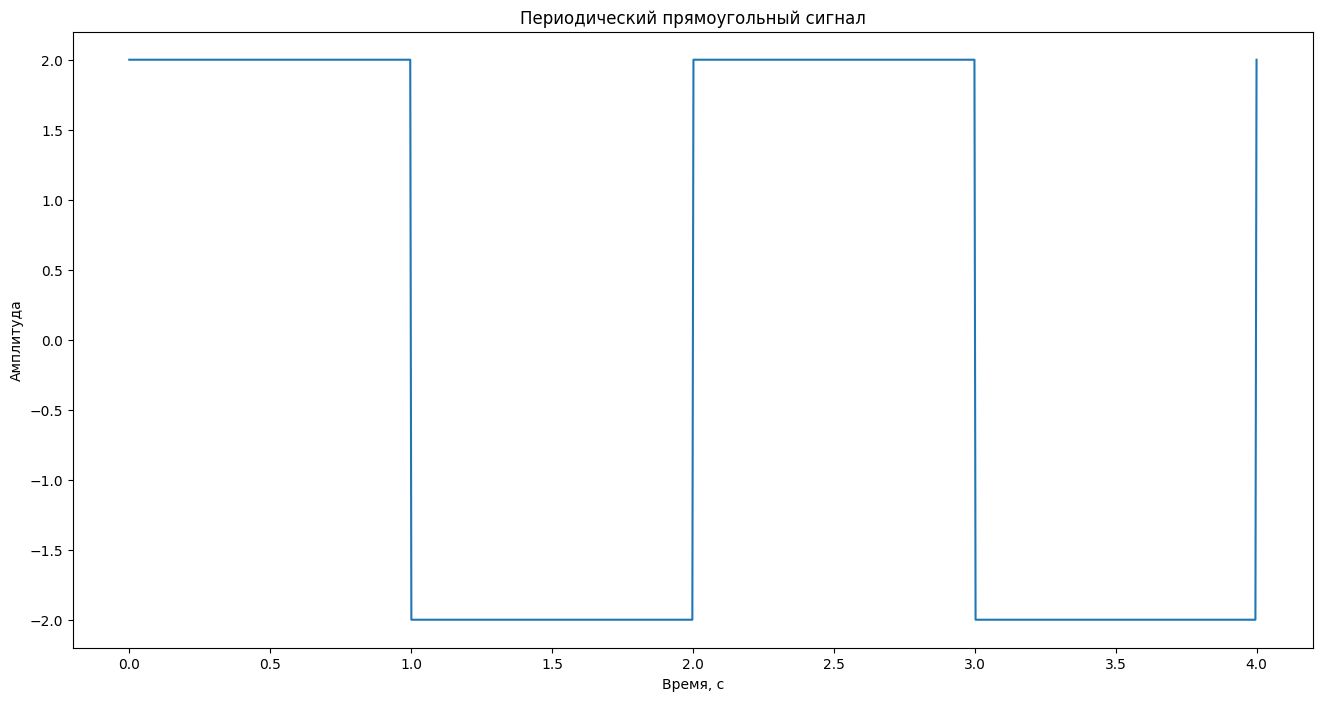

In [2]:
square_signal, square_time_series = calc_signal(rec_imp, t_end=4, steps_cnt=1000)

fig = plt.figure(figsize=(16,8))

plt.title("Периодический прямоугольный сигнал")
plt.ylabel("Амплитуда")
plt.xlabel("Время, с")
plt.plot(square_time_series, square_signal)
plt.show()

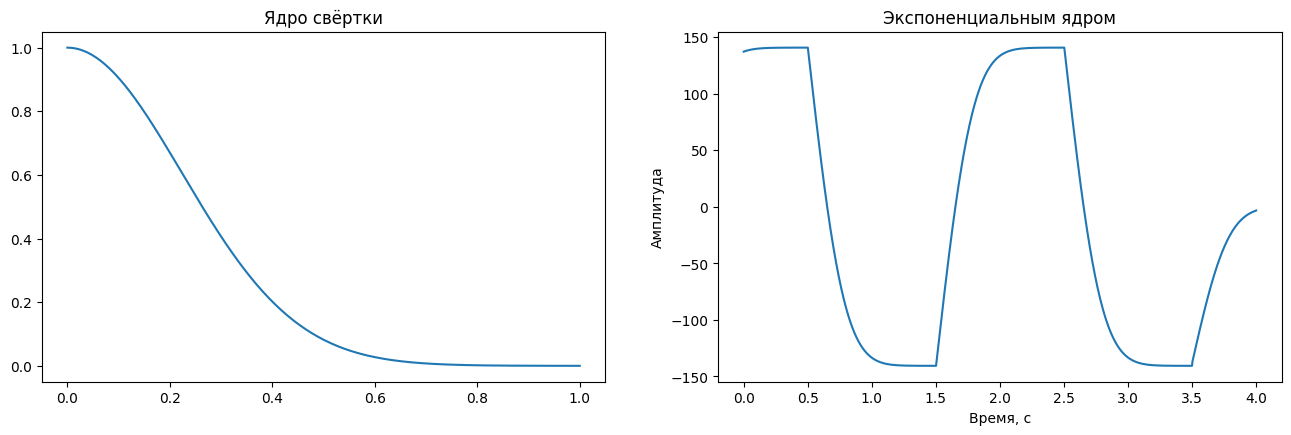

In [3]:
def kernel_exp(x, A):
    return A*np.exp(-np.power(x, 2)/0.1)

kernel_xs = np.linspace(0, 1, 250)
kernel_expo_vals = kernel_exp(kernel_xs, 1)

fig = plt.figure(figsize=(16,10))

plt.subplot(221)
plt.title("Ядро свёртки")
plt.plot(kernel_xs, kernel_expo_vals)

square_conved = np.convolve(square_signal, kernel_expo_vals, 'same')

plt.subplot(222)
plt.title("Экспоненциальным ядром")
plt.ylabel("Амплитуда")
plt.xlabel("Время, с")
plt.plot(square_time_series, square_conved)

plt.show()

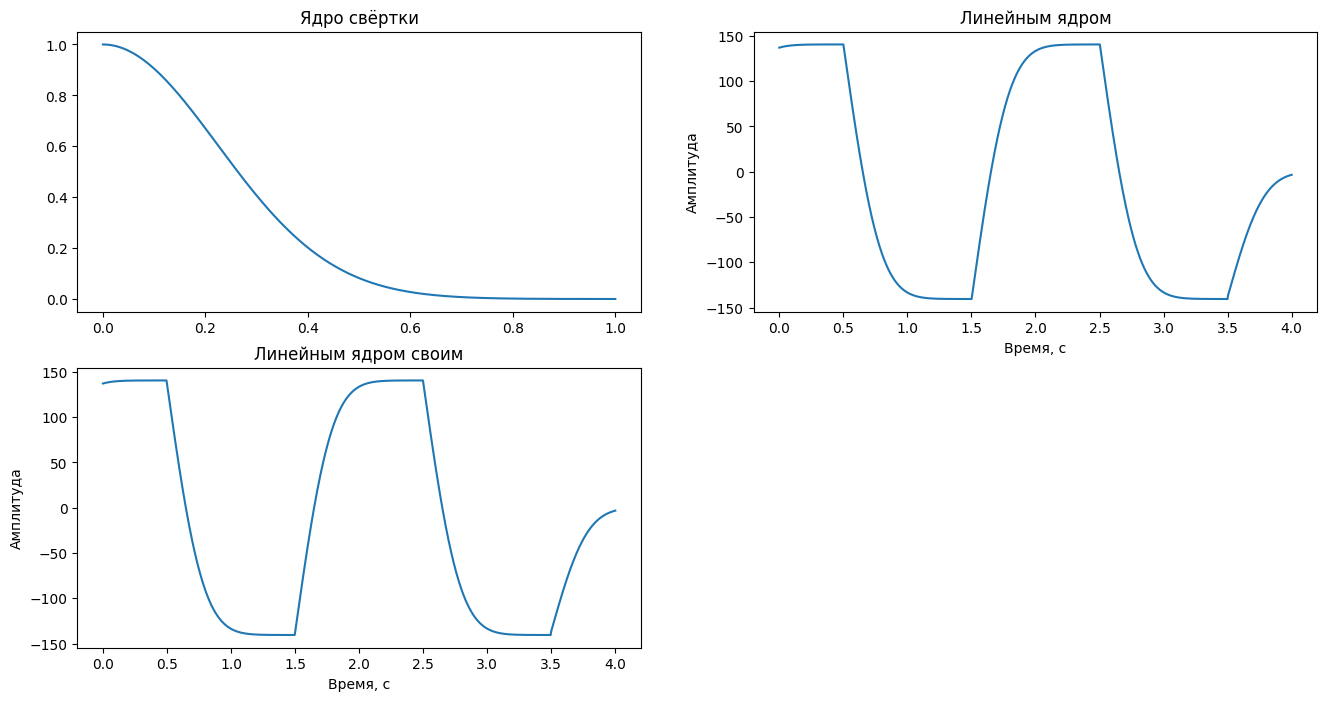

0.004

In [4]:
def kernel_linear(a, x, b):
    return a * x + b

kernel_xs = np.linspace(0, 1, 250)
kernel_linear_vals = kernel_linear(1, kernel_xs, 5)
# kernel_xs = np.linspace(0, 1, 250)
kernel_expo_vals = kernel_exp(kernel_xs, 1)

square_conved = np.convolve(square_signal, kernel_expo_vals, 'same')




def conv(signal, filter_kernel):
    # Определяем длины сигнала и ядра
    signal_length = len(signal)
    kernel_length = len(filter_kernel)

    # Дополняем сигнал и ядро нулями до нужной длины
    padded_signal = np.pad(signal, (0, kernel_length - 1), 'constant')
    padded_kernel = np.pad(filter_kernel, (0, signal_length - 1), 'constant')

    # Применяем преобразование Фурье к сигналу и ядру свертки
    signal_fft = np.fft.fft(padded_signal)
    kernel_fft = np.fft.fft(padded_kernel)

    # Выполняем поэлементное умножение в частотной области
    result_fft = signal_fft * kernel_fft

    # Применяем обратное преобразование Фурье и коррекцию амплитуд
    result = np.fft.ifft(result_fft)

    # Сдвигаем результат, чтобы учесть разницу в нулевых значениях
    result = np.roll(result, -kernel_length // 2)[:signal_length]

    return np.real(result)

fig = plt.figure(figsize=(16,8))

plt.subplot(221)
plt.title("Ядро свёртки")
plt.plot(kernel_xs, kernel_expo_vals)

plt.subplot(222)
plt.title("Линейным ядром")
plt.ylabel("Амплитуда")
plt.xlabel("Время, с")
plt.plot(square_time_series, square_conved)

square_conved = conv(square_signal, kernel_expo_vals)
plt.subplot(223)
plt.title("Линейным ядром своим")
plt.ylabel("Амплитуда")
plt.xlabel("Время, с")
plt.plot(square_time_series, square_conved)

plt.show()
np.mean(square_signal)

In [5]:
def extend_arr(arr, axis_0_len):
    l = list(arr)
    l_orig = l.copy()
    while len(l) < axis_0_len:
        l += l_orig
    return np.array(l)[:axis_0_len]

def fft_full(xs, ys, normalize=False):
    spectrum = np.fft.fft(ys)
    if normalize: normalize(spectrum)
    freq_series = np.fft.fftfreq(len(xs), 1/len(xs))
    return [freq_series, (spectrum)]

def normalize(arr, id=None):
    if id is None and len(arr) > 6: return arr/np.max(arr)

    arr[id] = arr[id]/np.max(arr[id])
    return arr

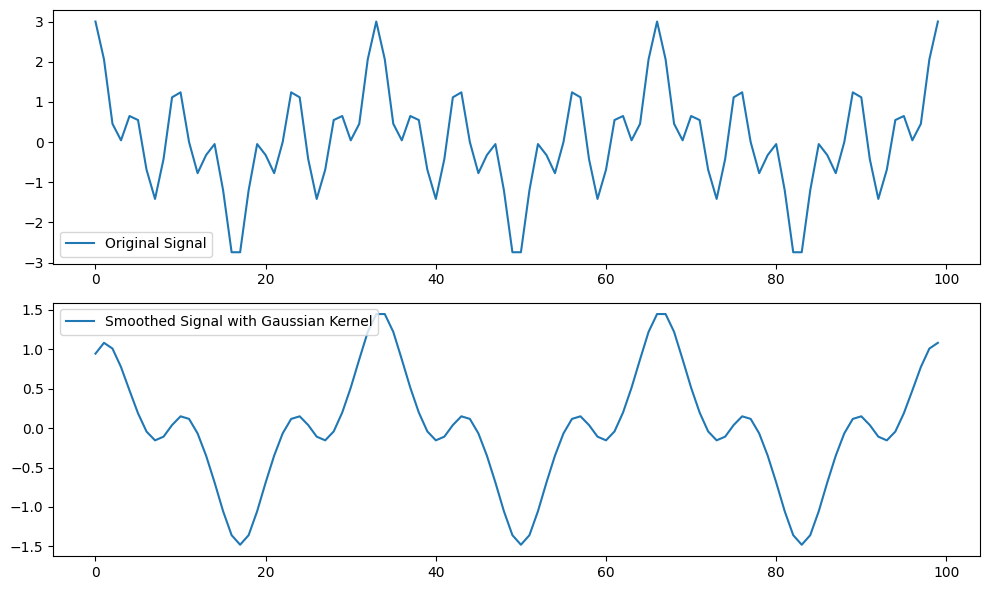

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve

def gaussian_kernel(size, sigma=1):
    """Генерация ядра Гаусса"""
    kernel = np.fromfunction(
        lambda x: (1/ (np.sqrt(2 * np.pi) * sigma)) * np.exp(-(x - (size - 1) / 2) ** 2 / (2 * sigma ** 2)),
        (size,)
    )
    return kernel / np.sum(kernel)

def gaussian_smooth(signal, kernel_size=3, sigma=1):
    """Сглаживание сигнала с использованием свертки с ядром Гаусса"""
    kernel = gaussian_kernel(kernel_size, sigma)
    smoothed_signal = convolve(signal, kernel, mode='same', method='direct')
    return smoothed_signal

# Пример использования

# Создаем пример сигнала
signal_length = 100
cos_50f = cosinus_signal_func(50)
cos_150f = cosinus_signal_func(150)
cos_250f = cosinus_signal_func(350)
cos_sum = lambda t: cos_50f(t) + cos_150f(t) + cos_250f(t)
cos_sum_vals, cos_sum_time = calc_signal(cos_sum, t_end=6, steps_cnt=100)

# Задаем параметры ядра Гаусса
kernel_size = 100
sigma = 2

# Выполняем сглаживание сигнала
smoothed_signal = gaussian_smooth(cos_sum_vals, kernel_size, sigma)

# Визуализируем результаты
plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.plot(cos_sum_vals, label='Original Signal')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(smoothed_signal, label='Smoothed Signal with Gaussian Kernel')
plt.legend()

plt.tight_layout()
plt.show()


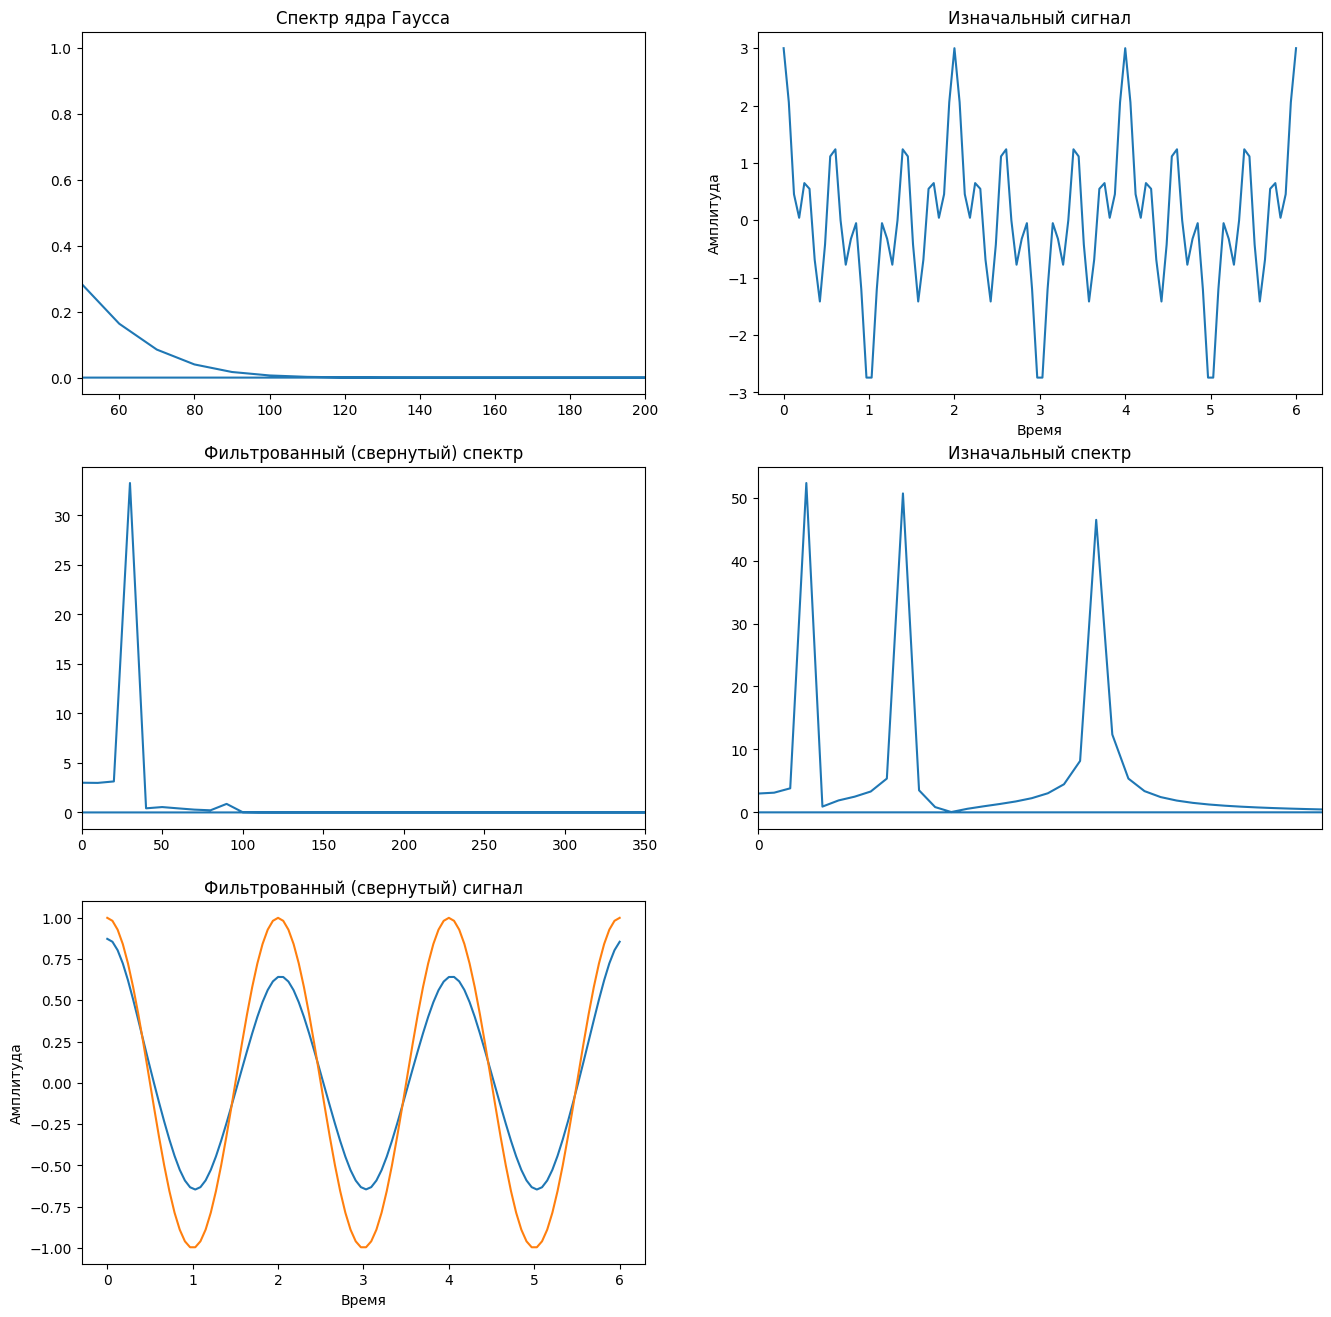

In [49]:
def gaussian_frequency_kernel(frequencies, peak_frequency, FWHM):
    s = (FWHM * (2 * np.pi - 1)) / (4 * np.pi)
    kernel = np.exp(-0.5 * ((frequencies - peak_frequency) / s) ** 2)
    return kernel

sample_rate = 1000
peak_frequency = 0 # target freq
FWHM = 75  # width

# Создаем частотный массив
frequencies = np.fft.fftfreq(len(cos_sum_time), 1.0 / sample_rate)

frequency_kernel = gaussian_frequency_kernel(frequencies, peak_frequency, FWHM)

spectrum_cos_sum = np.abs(np.fft.fft(cos_sum_vals))
conved_cos_sum = frequency_kernel * spectrum_cos_sum

plt.figure(figsize=(16, 16))
cos_50f = cosinus_signal_func(50)
cos_50_vals, cos_50_time = calc_signal(cos_50f, t_end=6, steps_cnt=100)


plt.subplot(321)
plt.plot(frequencies, np.abs(frequency_kernel))
plt.title('Cпектр ядра Гаусса')
plt.xlim([50, 200])

plt.subplot(322)
plt.title("Изначальный сигнал")
plt.plot(cos_sum_time, cos_sum_vals)
plt.xlabel('Время')
plt.ylabel('Амплитуда')

plt.subplot(323)
plt.title("Фильтрованный (свернутый) спектр")
plt.plot(frequencies, conved_cos_sum)
plt.xlim([0, 350])

plt.subplot(324)
plt.title("Изначальный спектр")
plt.plot(frequencies, np.abs(np.fft.fft(cos_sum_vals)))
plt.xticks([0])
plt.xlim([0, 350])

plt.subplot(325)
plt.title("Фильтрованный (свернутый) сигнал")
plt.plot(cos_sum_time, np.fft.ifft(conved_cos_sum))
plt.plot(cos_sum_time,cos_50_vals)
plt.xlabel('Время')
plt.ylabel('Амплитуда')

plt.show()


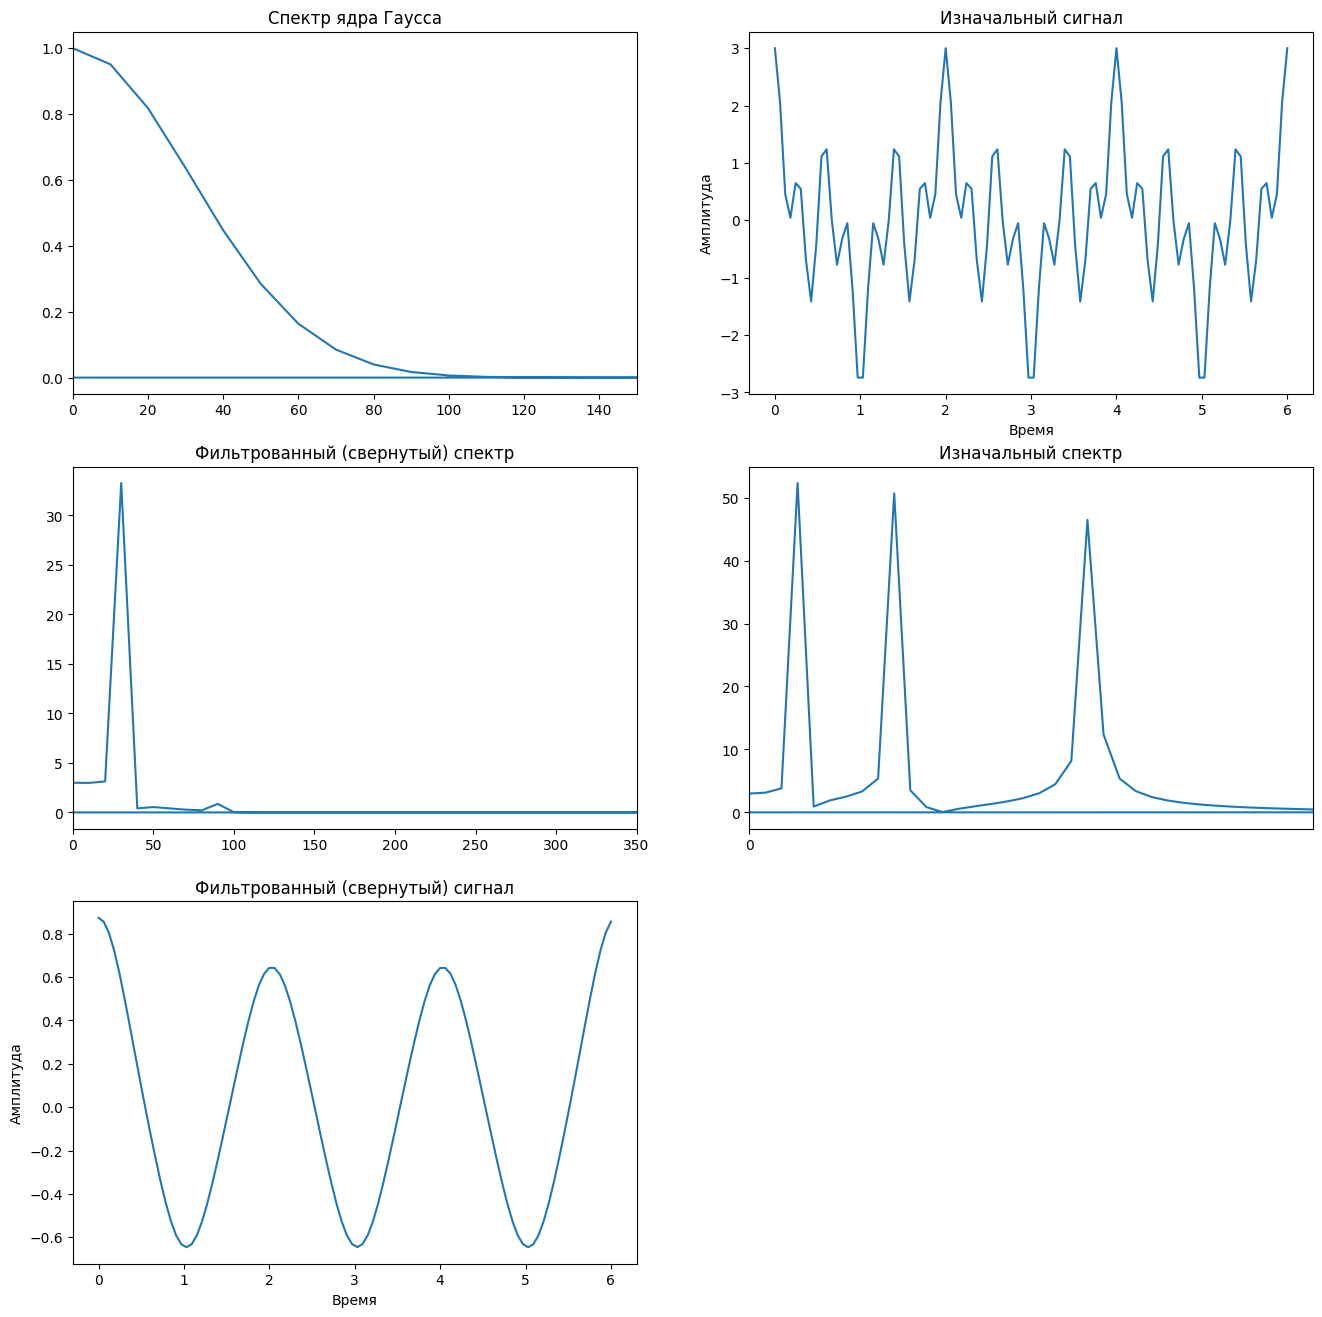

In [8]:
def gaussian_frequency_kernel(frequencies, peak_frequency, FWHM):
    s = (FWHM * (2 * np.pi - 1)) / (4 * np.pi)
    kernel = np.exp(-0.5 * ((frequencies - peak_frequency) / s) ** 2)
    return kernel

sample_rate = 1000
peak_frequency = 0 # target freq
FWHM = 75  # width

# Создаем частотный массив
frequencies = np.fft.fftfreq(len(cos_sum_time), 1.0 / sample_rate)

frequency_kernel = gaussian_frequency_kernel(frequencies, peak_frequency, FWHM)

spectrum_cos_sum = np.abs(np.fft.fft(cos_sum_vals))
conved_cos_sum = frequency_kernel * spectrum_cos_sum

plt.figure(figsize=(16, 16))

plt.subplot(321)
plt.plot(frequencies, np.abs(frequency_kernel))
plt.title('Cпектр ядра Гаусса')
plt.xlim([0, 150])

plt.subplot(322)
plt.title("Изначальный сигнал")
plt.plot(cos_sum_time, cos_sum_vals)
plt.xlabel('Время')
plt.ylabel('Амплитуда')

plt.subplot(323)
plt.title("Фильтрованный (свернутый) спектр")
plt.plot(frequencies, conved_cos_sum)
plt.xlim([0, 350])

plt.subplot(324)
plt.title("Изначальный спектр")
plt.plot(frequencies, np.abs(np.fft.fft(cos_sum_vals)))
plt.xticks([0])
plt.xlim([0, 350])

plt.subplot(325)
plt.title("Фильтрованный (свернутый) сигнал")
plt.plot(cos_sum_time, np.fft.ifft(conved_cos_sum))
plt.xlabel('Время')
plt.ylabel('Амплитуда')

plt.show()

In [22]:
def a(k, eps, N):
    za = lambda k, eps, N: eps * (N - 1) * (1 / k + 1 / (k - eps * (N - 1)))
    zb = lambda k, eps, N: eps * (N - 1) * (1 / (N - 1 - k) + 1 / (-k + (1 - eps) * (N - 1)))

    if k == 0 or k == N - 1:     return 0
    if k < eps * (N - 1):        return 1 / (np.exp(za(k, eps, N)) + 1)
    if k <= (1 - eps) * (N - 1): return 1
    if k < N - 1:                return 1 / (np.exp(zb(k, eps, N)) + 1)
    return 0

def plank(eps, fwhm, m_len=200):
    plank = [a(k, eps, fwhm) for k in range(fwhm)]
    return np.pad(plank, (0, m_len-len(plank)))

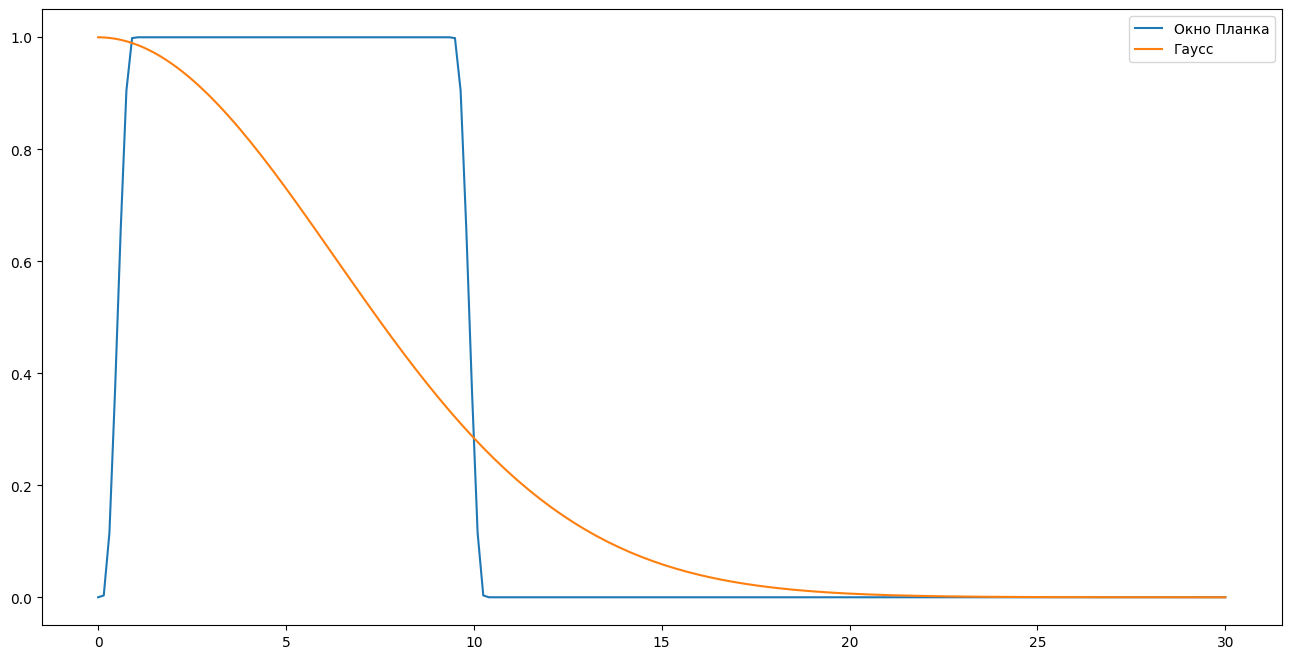

In [24]:
planka = plank(0.1,70)
frequencies = np.linspace(0, 30, 200)
peak_frequency = 0 # target freq
FWHM = 15  # width
gaus_freqs = gaussian_frequency_kernel(frequencies, peak_frequency, FWHM)
#filtred_plank = spectrum_cos_sum * planka
fig = plt.figure(figsize=(16,8))
plt.plot(frequencies, planka, label="Окно Планка")
plt.plot(frequencies, gaus_freqs, label="Гаусс")

plt.legend()
plt.show()

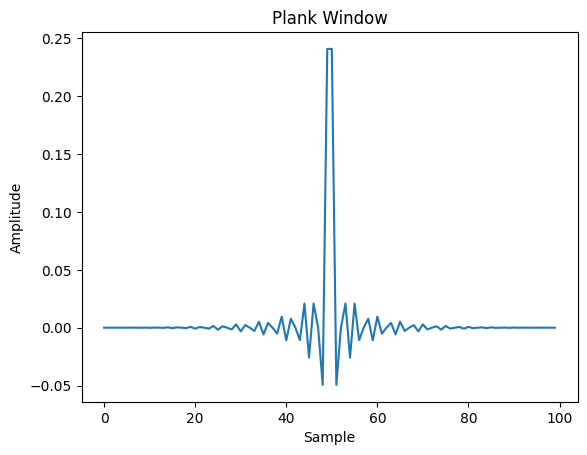

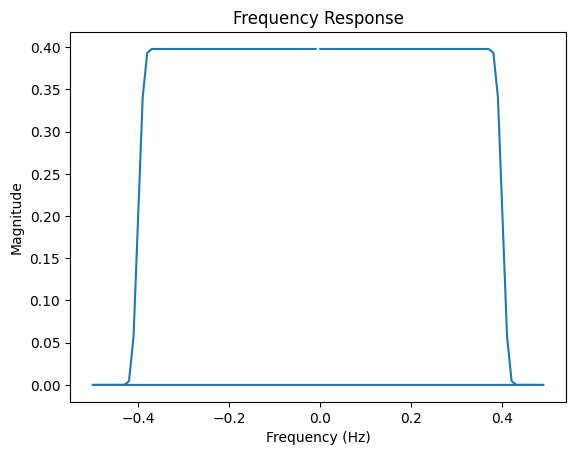

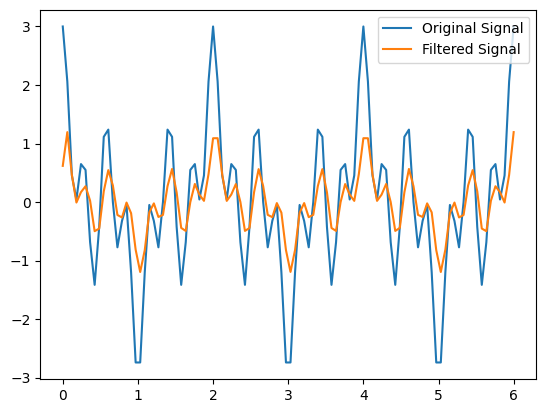

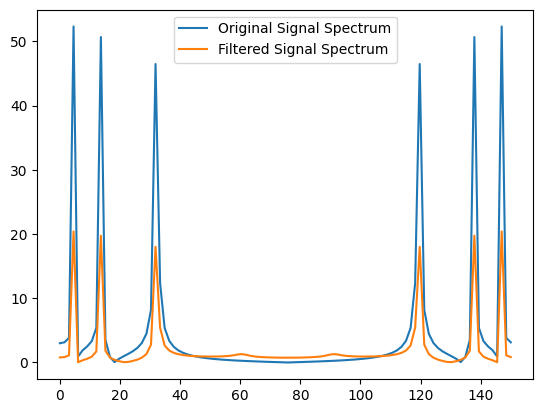

In [52]:
import numpy as np
import matplotlib.pyplot as plt

def plank_window(N, low_cutoff, high_cutoff):
    # Создание окна Планка для полосового фильтра
    n = np.arange(N)
    window = np.sinc(2 * (high_cutoff - low_cutoff) * (n - (N-1)/2)) / np.pi
    window *= np.blackman(N)  # Окно Блэкмана для уменьшения смещения

    return window

def plot_frequency_response(signal, dt):
    # Визуализация частотной характеристики
    frequency = np.fft.fftfreq(len(signal), dt)
    magnitude = np.abs(np.fft.fft(signal))
    
    plt.plot(frequency, magnitude)
    plt.title('Frequency Response')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude')
    plt.show()

# Параметры фильтра
N = 100  # Размер окна
low_cutoff = 0.2  # Нижняя граница полосы пропускания
high_cutoff = 0.6  # Верхняя граница полосы пропускания
frequencies = np.linspace(0, 150, 100)
# Создание полосового фильтра с использованием окна Планка
plank_filter = plank_window(N, low_cutoff, high_cutoff)
spectrum_cos_sum = np.abs(np.fft.fft(cos_sum_vals))
# Визуализация окна Планка
plt.plot(plank_filter)
plt.title('Plank Window')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.show()

# Визуализация частотной характеристики фильтра
plot_frequency_response(plank_filter, dt=1.0)

# Применение фильтра к сигналу
# Здесь signal - ваш исходный сигнал
filtered_signal = np.convolve(cos_sum_vals, plank_filter, mode='same')
spectrum_filtred = np.abs(np.fft.fft(filtered_signal))
# Визуализация отфильтрованного сигнала (закомментировано, так как signal не определен)
plt.plot(cos_sum_time,cos_sum_vals, label='Original Signal')
plt.plot(cos_sum_time,filtered_signal, label='Filtered Signal')
plt.legend()
plt.show()
plt.plot(frequencies,abs(spectrum_cos_sum), label='Original Signal Spectrum')
plt.plot(frequencies,abs(spectrum_filtred), label='Filtered Signal Spectrum')

plt.legend()
plt.show()


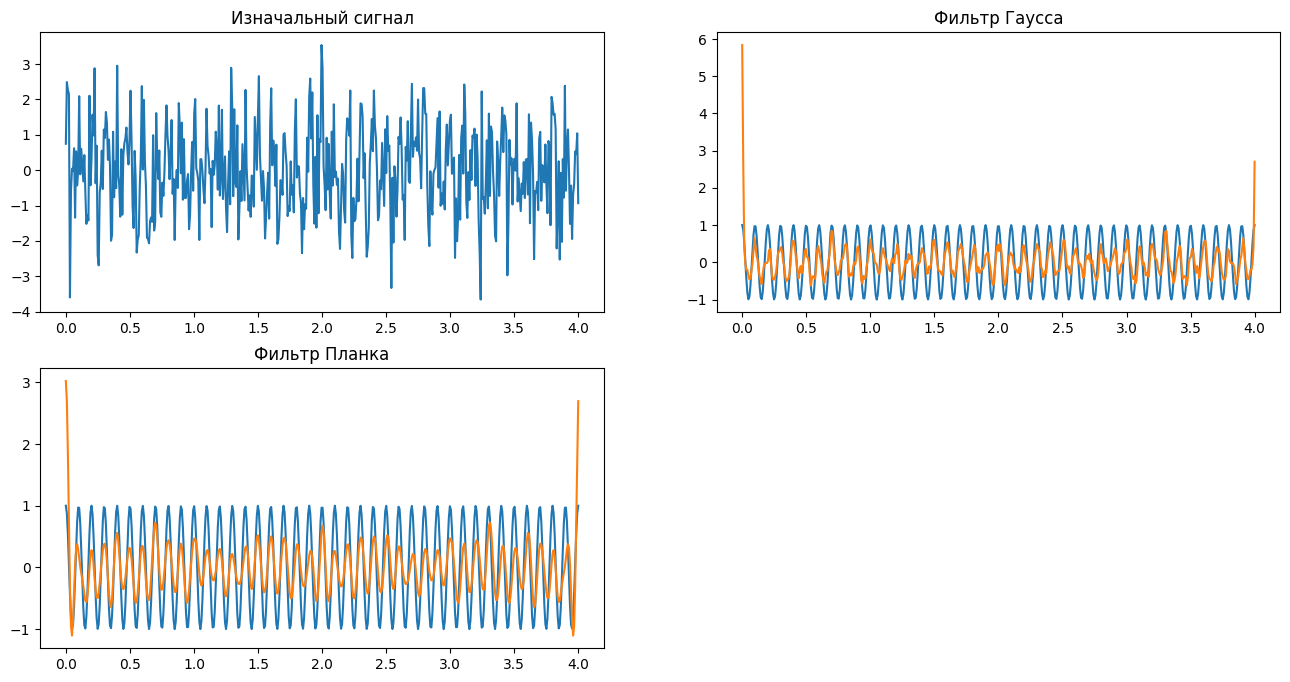

In [11]:
samples_rate = 500

frequencies = np.linspace(0, 30, samples_rate)
planka = plank(0.1,70, samples_rate)

peak_frequency = 0 # target freq
FWHM = 15  # width
gaus_freqs = gaussian_frequency_kernel(frequencies, peak_frequency, FWHM)

cos_noised = cosinus_signal_func(freq=10)
cos_noised_vals, cos_noised_time = calc_signal(cos_noised, t_end=4, steps_cnt=samples_rate, noised=True)
cos_vals, cos_time = calc_signal(cos_noised, t_end=4, steps_cnt=samples_rate)

spectrum_cos_signal = np.abs(np.fft.fft(cos_noised_vals))
gaus_filtered  = np.fft.ifft(gaus_freqs * spectrum_cos_signal)
plank_filtered = np.fft.ifft(planka * spectrum_cos_signal)

plt.figure(figsize=(16, 8))

plt.subplot(221)
plt.plot(cos_noised_time, cos_noised_vals)
plt.title('Изначальный сигнал')

plt.subplot(222)
plt.plot(cos_noised_time, cos_vals)
plt.plot(cos_noised_time, gaus_filtered)
plt.title('Фильтр Гаусса')

plt.subplot(223)
plt.plot(cos_noised_time, cos_vals)
plt.plot(cos_noised_time, plank_filtered)
plt.title('Фильтр Планка')

plt.show()